In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/image_course

/content/drive/MyDrive/image_course


In [ ]:
import gensim
import gensim.downloader as api
import pandas as pd
import re
import numpy as np
from nltk import ngrams
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ',' ',' ']

    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)

    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)

    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    #trim
    text = text.strip()

    return text

def remove_non_arabic(text):
    return re.sub(r'[^\u0600-\u06FF\s]', '', text)



def remove_stopwords(text):
    stop_words = set(stopwords.words('arabic'))
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words])


def stem_words(text):
    stemmer = ISRIStemmer()
    words = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in words])


def get_vec(n_model,dim, token):
    vec = np.zeros(dim)
    is_vec = False
    if token not in n_model.wv:
        _count = 0
        is_vec = True
        for w in token.split("_"):
            if w in n_model.wv:
                _count += 1
                vec += n_model.wv[w]
        if _count > 0:
            vec = vec / _count
    else:
        vec = n_model.wv[token]
    return vec

def calc_vec(pos_tokens, neg_tokens, n_model, dim):
    vec = np.zeros(dim)
    for p in pos_tokens:
        vec += get_vec(n_model,dim,p)
    for n in neg_tokens:
        vec -= get_vec(n_model,dim,n)

    return vec

## -- Retrieve all ngrams for a text in between a specific range
def get_all_ngrams(text, nrange=3):
    text = re.sub(r'[\,\.\;\(\)\[\]\_\+\#\@\!\?\؟\^]', ' ', text)
    tokens = [token for token in text.split(" ") if token.strip() != ""]
    ngs = []
    for n in range(2,nrange+1):
        ngs += [ng for ng in ngrams(tokens, n)]
    return ["_".join(ng) for ng in ngs if len(ng)>0 ]

## -- Retrieve all ngrams for a text in a specific n
def get_ngrams(text, n=2):
    text = re.sub(r'[\,\.\;\(\)\[\]\_\+\#\@\!\?\؟\^]', ' ', text)
    tokens = [token for token in text.split(" ") if token.strip() != ""]
    ngs = [ng for ng in ngrams(tokens, n)]
    return ["_".join(ng) for ng in ngs if len(ng)>0 ]

## -- filter the existed tokens in a specific model
def get_existed_tokens(tokens, n_model):
    return [tok for tok in tokens if tok in n_model.wv ]
def remove_punc(text):
  arabic_punctuations = r'''[،؛؟!.؟]'''
  cleaned_text = re.sub(arabic_punctuations, '', text)
  return cleaned_text

def preprocess_text(text):
    text = clean_str(text)
    text = remove_non_arabic(text)
    #text = remove_stopwords(text)
    text = remove_punc(text)
    #text = stem_words(text)
    #tokenized_text =  model.wv.get_mean_vector(text)
    return text

In [ ]:
#!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
#!unzip full_grams_cbow_300_twitter.zip

In [ ]:
#model_path = '/content/drive/MyDrive/image_course/full_grams_cbow_300_twitter.mdl'

In [ ]:
# load the AraVec model
#model = gensim.models.Word2Vec.load(model_path)


In [ ]:
dataset_path = '/content/drive/MyDrive/image_course/Dataset.tsv'
df = pd.read_csv(dataset_path, sep='\t')
df.shape

(99999, 2)

In [ ]:
df['sentiment_id'] = df['label'].map({'Negative': 0, 'Positive': 1, 'Mixed': 2})

In [ ]:

df['pre_text'] = df['text'].apply(preprocess_text)

In [ ]:
df['len'] = df['pre_text'].apply(len)
sorted_df = df.sort_values(by='len')


In [ ]:
zero_count = df['len'].value_counts().get(0, 0)
zero_count

4

In [ ]:
df = df[df['len'] != 0]

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df['split_pre_text'] = df['pre_text'].apply(lambda x: x.split(' '))

In [ ]:
#df['splited_token_pre_text'] = df['split_pre_text'].apply(lambda x: [model.wv[word] for word in x if word in model.wv])

In [ ]:
#df['token_pre_text1'] = df['split_pre_text'].apply(model.wv.get_mean_vector)


In [ ]:

unique_words = set()
for row in df['split_pre_text']:
  for word in row:
    unique_words.add(word)

num_unique_words = len(unique_words)
print(f"The number of unique words in the 'split_pre_text' column is: {num_unique_words}")

The number of unique words in the 'split_pre_text' column is: 285077


In [ ]:
longest_list = max(df['split_pre_text'], key=len)

print("The longest list is:", longest_list)

print("The len longest list is:", len(longest_list))

index_of_longest = df['split_pre_text'].apply(len).idxmax()
print(index_of_longest)

The longest list is: ['في', 'بدايه', 'الامر', 'اعجبني', 'سرد', 'الاحداث', 'وبعض', 'الاقتباسات', 'والفكره', 'العامه', 'للقصه', 'الا', 'ان', 'هناك', 'الكثير', 'من', 'الامور', 'يصعب', 'تجاهلها', 'وانا', 'اتفق', 'مع', 'هذا', 'النقد', 'من', 'اكثر', 'الروايات', 'التي', 'حيرتني', 'علي', 'الاطلاق', 'هذه', 'الروايه', 'جذبتني', 'بدايه', 'من', 'العنوان', 'الذي', 'اختارته', 'الكاتبه', 'لها', 'ولا', 'انكر', 'انني', 'في', 'الاجزاء', 'الاولي', 'كانت', 'لدي', 'رغبه', 'كبيره', 'في', 'انهاء', 'قراتها', 'لمعرفه', 'سير', 'الاحداث', 'المتتابعه', 'كما', 'ان', 'وجود', 'العامل', 'الصوفي', 'ساهم', 'في', 'جذبي', 'علي', 'نحو', 'كبير', 'لما', 'له', 'من', 'اثر', 'غامض', 'يحث', 'اي', 'شخص', 'لمعرفه', 'المزيد', 'عن', 'هذا', 'العالم', 'وربما', 'لو', 'ان', 'الروايه', 'كانت', 'تتحدث', 'عن', 'شئ', 'لا', 'يمت', 'للاسلام', 'لربما', 'اعطيتها', 'اربع', 'او', 'خمس', 'نجمات', 'لكن', 'وبما', 'انها', 'تتحدث', 'عن', 'هذا', 'الدين', 'الذي', 'انتمي', 'له', 'وافخر', 'بذلك', 'فهنا', 'كان', 'الزاما', 'علي', 'ان', 'اتاني', 'بتقيم', 'ا

In [ ]:
longest_list = max(df['pre_text'], key=len)

print("The longest list is:", longest_list)

print("The len longest list is:", len(longest_list))

index_of_longest = df['pre_text'].apply(len).idxmax()
print(index_of_longest)

The longest list is: لو استطعت ان اعطيه تقيم اعلي لفعلت اعجابي بهذا الشيخ الجليل جعلني متيقن انني ساعمل علي اقتناء كافه اعماله رحمه الله بهذا العلم مقتطفات من كتاب جدد حياتك محمد الغزالي ان نبي الاسلام لما قال للسائل عن البر استفت قلبك لم يقدم هذا الجواب هديه لمجرم يستبيح الدماء ويغتال الحقوق انه ساق هذا الجواب لرجل يتحرج الالمام بصغيره رجل سليم الفطره شفاف الجوهر عاشق للخير اراد النبي الكريم ان يريحه من عناء التساول والاستفتاء فرده الي فؤاده يستلهمه الرشد كلما تشابهت امامه الامور ويستريح الي اجابته وان اكثر عليه المفتون هذا الرجل وامثاله من اصحاب القلوب الكبيره هم موازين العالم ومناراته الهاديه ولعمري ان الحياه من غير هؤلاء باطل  العقل مهما سما لن يستغني عن النقل كما ان الذكاء لا يستغني عن قواعد العلوم وفنون المعرفه  وجدير بالانسان ف عالم استوحش فيه الحق علي هذا النحو ان يجتهد ف تحريه وان يلتزم الاخذ به وان يرجع اليه كلما ابعدته التيارات عنه ولعل هذا هو السر ف ان الله طلب من المؤمن ان يساله الهدي وكلفه الا يسام من تكرار هذا السؤال ففي كل صلاه مفروضه او نافله يقف المرء بين يدي الله ويق

In [ ]:
texts = df['pre_text'].tolist()


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['pre_text'], df['sentiment_id'], test_size=0.1, stratify=df['sentiment_id'], random_state=42)

In [ ]:
import tensorflow as tf
import keras
import numpy as np # import numpy here
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer


vocab_size = 285078

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 8080

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

y_train = np.array(y_train)
y_test = np.array(y_test)

embedding_dim = 100
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# RNN layer
model.add(LSTM(16, return_sequences=False))

model.add(Dense(16, activation = 'relu'))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train_padded, y_train,batch_size=64,epochs=3, validation_data=(X_test_padded, y_test) ,callbacks=[EarlyStopping(monitor='val_accuracy', mode='min', patience=5)])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 351s 248ms/step - accuracy: 0.5674 - loss: 0.8695 - val_accuracy: 0.6837 - val_loss: 0.6849
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 379s 246ms/step - accuracy: 0.8143 - loss: 0.4662 - val_accuracy: 0.6649 - val_loss: 0.8095
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 382s 246ms/step - accuracy: 0.9106 - loss: 0.2416 - val_accuracy: 0.6629 - val_loss: 1.0490


In [ ]:
preds = (model.predict(X_test_padded) > 0.5).astype("int32")

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step


In [ ]:
model.save_weights('/content/drive/MyDrive/image_course/rnn4.weights.h5')


In [ ]:
y_pred_classes = np.argmax(preds, axis=1)

y_true = y_test

cm = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[2406  237  691]
 [ 341 2258  734]
 [ 720  664 1949]]


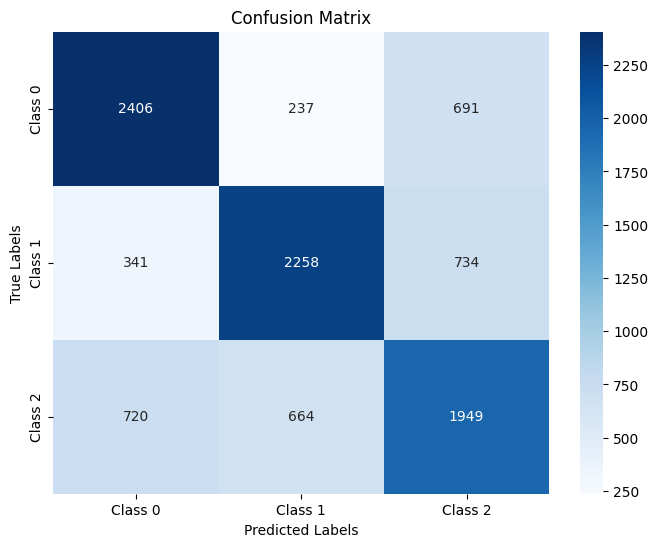

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
report = classification_report(y_true, y_pred_classes)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.72      0.71      3334
           1       0.71      0.68      0.70      3333
           2       0.58      0.58      0.58      3333

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



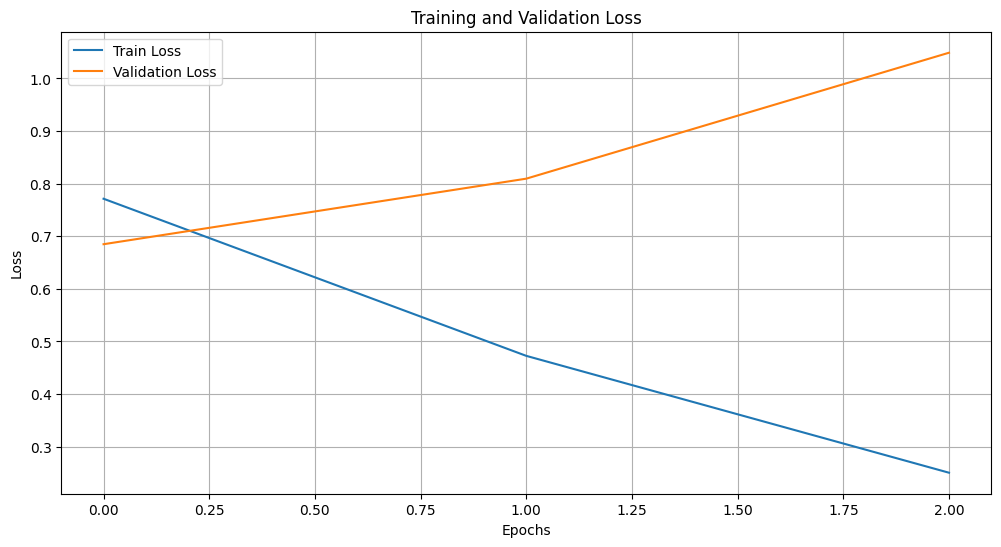

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
test_text = ['انا احب السبانخ',' ابغض الغباء  ']

test_text_pre = [preprocess_text(text) for text in test_text]
test_text_pre

['انا احب السبانخ', 'ابغض الغباء']

In [ ]:
for sentence in test_text_pre:

    input_vector = tokenizer.texts_to_sequences([sentence])


    input_vector = pad_sequences(input_vector, maxlen=max_length)

    input_vector = input_vector.reshape(1, -1)



    predictions = model.predict(input_vector)

    predicted_class = np.argmax(predictions, axis=1)

    print(f"Sentence: '{sentence}' | Predicted class: {predicted_class[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Sentence: 'انا احب السبانخ' | Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Sentence: 'ابغض الغباء' | Predicted class: 0
